# Spam Corpus Classification Based on Word Vectors
## using Spacy with large statistical model en_core_web_lg

## Read Spam Corpus

In [1]:
import sys
sys.path.append('..')

from spam_corpus import read_spam_corpus
spam_corpus = read_spam_corpus()
spam_corpus.dropna(inplace = True)
spam_corpus.head()

,text,label
0,\n> From: fork-admin@xent.com [mailto:fork-adm...,0
1,"Hi,\n\nOn Sun, 01 Sep 2002 00:05:03 MDT Reg Cl...",0
2,"On Fri Sep 13 2002 at 02:03, Robert Elz wrote:...",0
3,"On Thu, 2002-08-29 at 01:06, Matthias Saou wro...",0
4,"Hi, I'm building an rpm for the resin webserve...",0


## Feature Mining

In [3]:
import spacy

nlp = spacy.load('en_core_web_lg', disable=["tagger", "parser", "ner"])

In [4]:
from tqdm import tqdm
import numpy as np


X = np.array([nlp(text).vector for text in tqdm(spam_corpus.text)])
y = spam_corpus.label

100%|████████████████████████████████████████████████████████████████████████████| 10606/10606 [02:49<00:00, 62.59it/s]


In [5]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y, spam_corpus_train, spam_corpus_test = train_test_split(X, y, spam_corpus, random_state=42)

## Classification

### Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

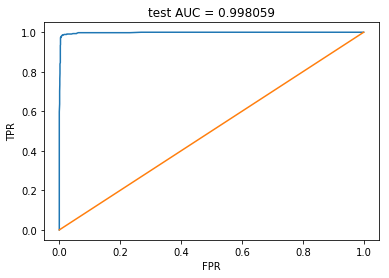

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve

test_predict_proba = clf.predict_proba(test_X)
test_predict_proba_pos = test_predict_proba[:, 1]
auc = roc_auc_score(test_y, test_predict_proba_pos)
curve = roc_curve(test_y, test_predict_proba_pos)


plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

to_labels = np.vectorize(lambda x: 1 if x > 0.5 else 0)
test_predict = to_labels(test_predict_proba_pos)

print('accuracy', accuracy_score(test_y, test_predict))
print('precision', precision_score(test_y, test_predict))
print('recall', recall_score(test_y, test_predict))
print('f1', f1_score(test_y, test_predict))
confusion_matrix(test_y, test_predict)

accuracy 0.9875565610859729
precision 0.9874429223744292
recall 0.9751972942502819
f1 0.9812819058423142


array([[1754,   11],
       [  22,  865]], dtype=int64)

In [9]:
import json

misclassified = spam_corpus_test[test_y == test_predict]
misclassified.to_json('.input/misclassified_spacy_lg.json', orient='table')

misclassified_dict = []
for index, sample in misclassified.iterrows(): 
        misclassified_dict.append({'index': index, 'label': sample.label, 'text': sample.text})